# Example - tuning Keras model and calibration parameters

In [1]:
from autotune.AutoTune import StepSearchCV

In [2]:
# prepare synthetic data to illustrate functionality

import numpy as np
X = np.random.normal(scale = 1, size = 100000).reshape(5000,20) #500 observations and 20 variables
y = X[:,0] + X[:,1] + X[:,0]* X[:,1]
X.shape, y.shape

((5000, 20), (5000,))

In [3]:
# Define class of keras models to navigate
import keras
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor 

def build_model(input_dim = 20, hidden_layer_sizes = [4,1], lr_init = 0.1, lr_decay = 0.001, activation = 'tanh', output_dim = 1, random_state = 7, early_stopping = False):
    tf.set_random_seed(random_state)
    np.random.seed(random_state)
    inputs  = keras.layers.Input((input_dim,), dtype='float32')
    for idx, hidden_layer_size in enumerate(hidden_layer_sizes):
        if idx == 0: hidden = keras.layers.Dense(hidden_layer_size, activation = activation)(inputs)
        else:        hidden = keras.layers.Dense(hidden_layer_size, activation = activation)(hidden)
    outputs = keras.layers.Dense(output_dim)(hidden) # no activation for the last layer
    model   = keras.Model(inputs, outputs)
    model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(lr=lr_init, decay = lr_decay))
    return model

my_model = KerasRegressor(build_fn = build_model)

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
searcher = StepSearchCV(
    estimator            = my_model,
    parameters_start     = {'lr_init': 0.1, 'hidden_layer_sizes': [4,1], 'activation': 'tanh', 'batch_size': 50, 'epochs': 2}, #, 'validation_split': 0.05
    param_options_str    = {'activation': ['tanh', 'sigmoid', 'relu', 'elu', 'linear']},
    scoring              = 'neg_mean_squared_error',
    save_location        = 'cv_results.csv',
    max_fit_time         = 60,
    tradeoff_scr_per_sec = 0.01/60
)

In [5]:
searcher.fit(X, y, steps = 50, verbose = 0)
# We could also continue tuning process where we left off by requesting more steps

Step 1 of 50, attempting adjustment Picked original parameters; Anticipating score improvement of 0.0
Step 2 of 50, attempting adjustment Explore: batch_size from 50 to 93; Anticipating score improvement of 0.0
Step 3 of 50, attempting adjustment Explore: batch_size from 50 to 96; Anticipating score improvement of -0.008247
Step 4 of 50, attempting adjustment batch_size from 50 to 41; Anticipating score improvement of 0.01252
Step 5 of 50, attempting adjustment Explore: lr_init from 0.1 to 0.06755; Anticipating score improvement of 0.0
Imroved score by 0.083 adopting parameters: 
 {'lr_init': 0.06755435595649759, 'hidden_layer_sizes': [4, 1], 'activation': 'tanh', 'batch_size': 50, 'epochs': 2}
Step 6 of 50, attempting adjustment Explore: activation from tanh to relu; Anticipating score improvement of 0.0
Step 7 of 50, attempting adjustment Explore: epochs from 2 to 1; Anticipating score improvement of 0.0
Step 8 of 50, attempting adjustment epochs from 2 to 6; Anticipating score impro

{'activation': 'tanh',
 'batch_size': 39,
 'epochs': 136,
 'hidden_layer_sizes': [19, 1],
 'lr_init': 0.025734239913534483}

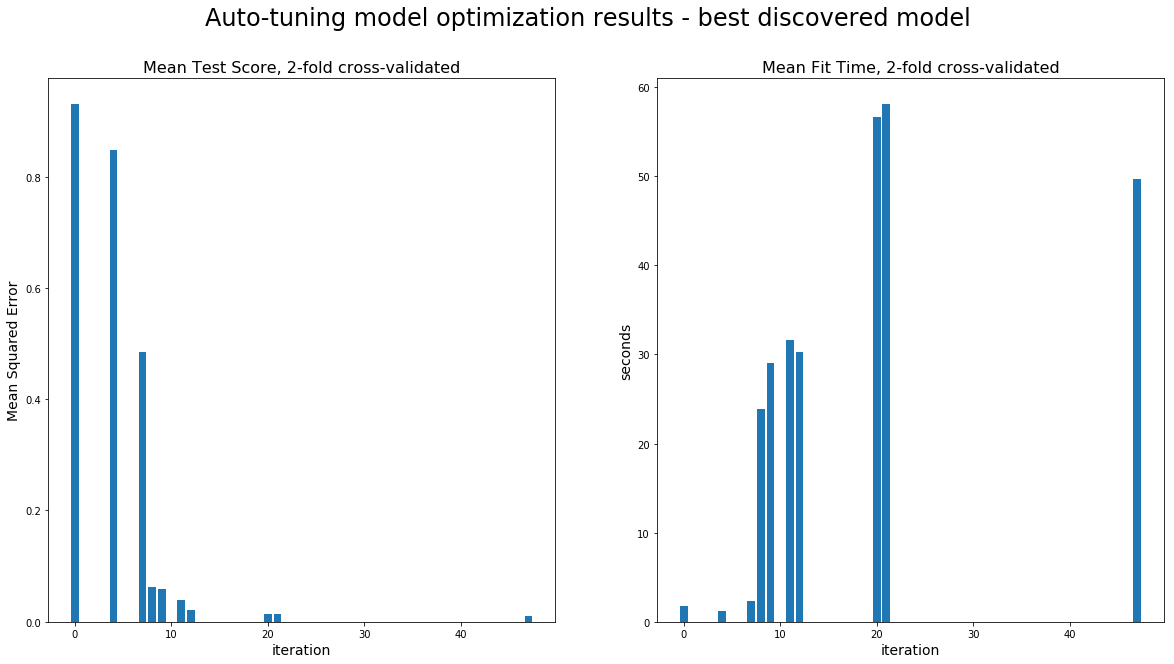

In [36]:
import matplotlib.pyplot as plt
def visualize_optimization(searcher):
    indices_improvement = [idx for idx, value in enumerate(searcher.results['improved']) if value ==True]
    #fig = plt.figure()
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,10))
    fig.suptitle('Auto-tuning model optimization results - best discovered model', size = 24)

    ax1.bar(indices_improvement,-1*searcher.results['mean_test_score'][indices_improvement])
    ax1.set_title('Mean Test Score, 2-fold cross-validated', size = 16)
    ax1.set_xlabel('iteration', size = 14)
    ax1.set_ylabel('Mean Squared Error'  , size = 14)
    ax1.set_ylim(bottom = 0)

    ax2.bar(indices_improvement,   searcher.results['mean_fit_time'][indices_improvement])
    ax2.set_title('Mean Fit Time, 2-fold cross-validated', size = 16)
    ax2.set_xlabel('iteration', size = 14)
    ax2.set_ylabel('seconds'  , size = 14)
    ax2.set_ylim(bottom = 0)
    plt.show()

visualize_optimization(searcher)

# Tunable call-backs
Next we'll try to add callbacks to the model we are trying to optimize.
Note it would be possible to tune them using the same functionality - e.g. enable / disable, or adjust parameters.

We'll try two callbacks, which could be defined from within model build function:
* Time Limit to ensure the auto-tune process doesn't waste time calibrating beyond selected time horizon - note when the model tuning process is stopped, the model may already be good enough.
* Early Stopping, to ensure model training phase ends when validation performance starts to deteriorate

In [78]:
import time
import keras
class TimeLimit(keras.callbacks.Callback):
    def __init__(self, time_limit_seconds, verbose = 1):
        self.time_limit_seconds = time_limit_seconds
        self.verbose = verbose
        
    def on_train_begin(self,logs={}):
        self.time_start = time.time()
        
    def on_epoch_end(self,epoch,logs):
        if time.time() >= self.time_start + self.time_limit_seconds:
            self.model.stop_training = True
            if self.verbose > 0: print('Training terminated after epoch ', epoch+1)

In [79]:
import keras
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor 

def build_model(input_dim = 20, hidden_layer_sizes = [4,1], lr_init = 0.1, lr_decay = 0.001, activation = 'tanh', output_dim = 1, random_state = 7, early_stopping = False, max_fit_time = 60):
    tf.set_random_seed(random_state)
    np.random.seed(random_state)
    inputs  = keras.layers.Input((input_dim,), dtype='float32')
    for idx, hidden_layer_size in enumerate(hidden_layer_sizes):
        if idx == 0: hidden = keras.layers.Dense(hidden_layer_size, activation = activation)(inputs)
        else:        hidden = keras.layers.Dense(hidden_layer_size, activation = activation)(hidden)
    outputs = keras.layers.Dense(output_dim)(hidden) # no activation for the last layer
    model   = keras.Model(inputs, outputs)
    #model.summary()
    model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(lr=lr_init, decay = lr_decay))

    # add callbacks to be utilized by the fit function - could check if 'callbacks_list' not in globals() 
    global callbacks_list 
    if 'callbacks_list' in globals(): callbacks_list.clear()
    
    if early_stopping == True:
        callbacks_list.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=1, mode='auto'))
    if max_fit_time: 
        callbacks_list.append(TimeLimit(max_fit_time))
    
    return model    


my_model = KerasRegressor(build_fn = build_model)

In [84]:
searcher_1 = StepSearchCV(
    estimator            = my_model,
    parameters_start     = {'lr_init': 0.1, 'hidden_layer_sizes': [4,1], 'activation': 'tanh', 'batch_size': 50, 'epochs': 2, 'validation_split': 0.05, 'early_stopping': False},
    param_options_str    = {'activation': ['tanh', 'sigmoid', 'relu', 'elu', 'linear']},
    scoring              = 'neg_mean_squared_error',
    save_location        = 'cv_results.csv',
    max_fit_time         = 60,
    tradeoff_scr_per_sec = 0.01/60
    #prior_results        = searcher
)

In [85]:
callbacks_list = []
# We could continue tuning process where we left off by requesting more steps
searcher_1.fit(X, y, steps = 20, verbose = 0, callbacks = callbacks_list)

Step 1 of 20, attempting adjustment Picked original parameters; Anticipating score improvement of 0.0
Step 2 of 20, attempting adjustment activation from tanh to relu; Anticipating score improvement of 0.0
Imroved score by 0.483 adopting parameters: 
 {'lr_init': 0.1, 'hidden_layer_sizes': [4, 1], 'activation': 'relu', 'batch_size': 50, 'epochs': 2, 'validation_split': 0.05, 'early_stopping': False}
Step 3 of 20, attempting adjustment Explore: hidden_layer_sizes from [4, 1] to [4, 2]; Anticipating score improvement of 0.0
Imroved score by 0.116 adopting parameters: 
 {'lr_init': 0.1, 'hidden_layer_sizes': [4, 2], 'activation': 'relu', 'batch_size': 50, 'epochs': 2, 'validation_split': 0.05, 'early_stopping': False}
Step 4 of 20, attempting adjustment Explore: batch_size from 50 to 19; Anticipating score improvement of 0.0
Imroved score by 0.216 adopting parameters: 
 {'lr_init': 0.1, 'hidden_layer_sizes': [4, 2], 'activation': 'relu', 'batch_size': 19, 'epochs': 2, 'validation_split': 

{'activation': 'relu',
 'batch_size': 9,
 'early_stopping': False,
 'epochs': 2,
 'hidden_layer_sizes': [4, 2],
 'lr_init': 0.03967242565707351,
 'validation_split': 0.05}

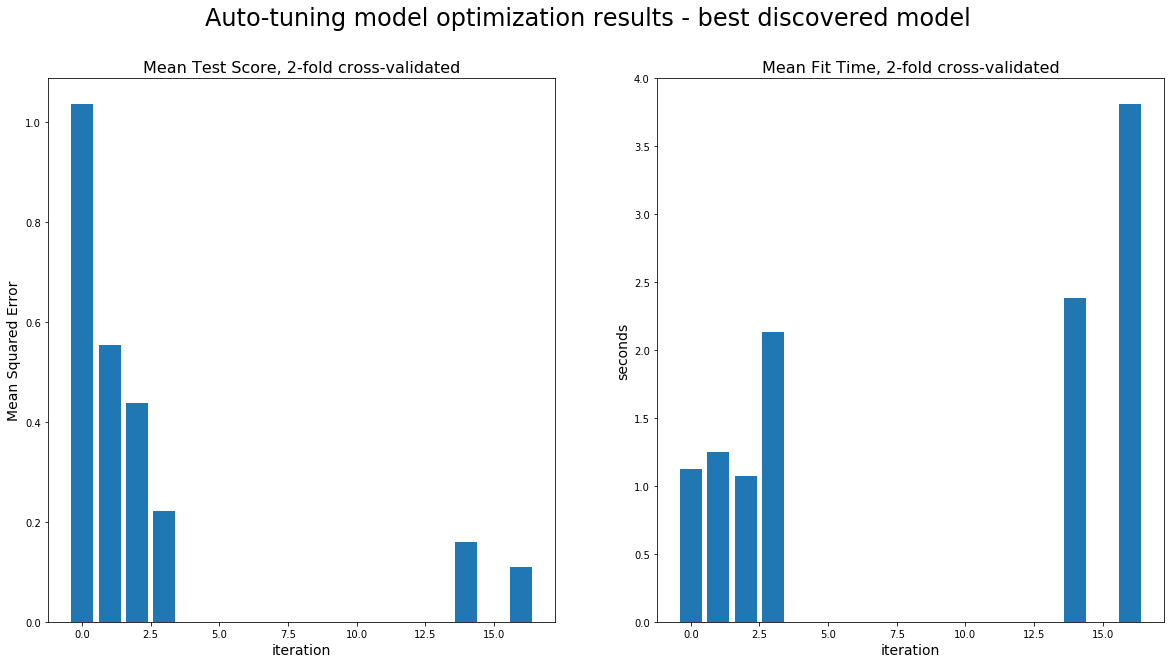

In [86]:
visualize_optimization(searcher_1)